# Sigmoid Multi-label Pipeline

Defaults: BCE loss, individual classifications per odor mixture

## Initialization

In [5]:
import pickle
import numpy as np
import importlib
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import csv


In [2]:
N = 500 # number of odors (max: 500)
M = 2 # number of odors per mixture

DSET_TYPE = "I" # one of [(B) binary, (U) noisy binary, (N) gaussian, (I) noisy intensities]

BATCH_SIZE = 64
NUM_EPOCHS = 100
SAVE = 1

# MODEL_TO_LOAD=None
MODEL_TO_LOAD = 'final_models/I_500_M1.pt'

DATASET = "sample" # one of ["all", "sample"]


In [7]:
import dataset
import rsample_dataset
importlib.reload(dataset)
importlib.reload(rsample_dataset)

# Quickly load pickled data, write to index_file for dataset lookup
def create_index(pickle_file, index_file):
    offsets = []
    with open(pickle_file, 'rb') as file:
        while True:
            offset = file.tell()
            try:
                pickle.load(file)
                offsets.append(offset)
            except EOFError:
                break
    with open(index_file, 'wb') as file:
        pickle.dump(offsets, file)


class AddGaussianNoise(object):
    """Add Gaussian noise to a tensor."""
    def __init__(self, mean=0.1, std=0.01):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Adds Gaussian noise to a tensor.
        """
        noise = np.random.randn(1781) * self.std + self.mean
        return tensor + noise


datafile = f'data/{DSET_TYPE}_{N}.pkl'
# datafile = 'data/I_500.pkl'
indexfile = f'indices/{DSET_TYPE}_{N}_train.idx'

create_index(datafile, indexfile)

# get new samples to train on
def new_loaders():
    dataset = rsample_dataset.RSampleDataset(
        pickle_file=datafile,
        index_file=indexfile,
        n_mixture=M,
        num_classes=N,
        transform=AddGaussianNoise(),
        total_samples=5000,
    )

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create DataLoader for training and validation
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader


## Model & Parameters

In [8]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, num_classes)  # Output logits, not probabilities

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x


model = SimpleNet(input_size=1781, num_classes=N)


# Load model weights
if MODEL_TO_LOAD:
    model.load_state_dict(torch.load(MODEL_TO_LOAD))
    print(f"Model loaded from {MODEL_TO_LOAD}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        # pos_weight should be a tensor of length equal to the number of classes
        # each weight corresponds to the positive class weight for each label
        self.pos_weight = pos_weight

    def forward(self, outputs, targets):
        # Initialize BCEWithLogitsLoss with pos_weight for handling class imbalance
        criterion = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        return criterion(outputs, targets)

# Assume higher weight for the positive classes due to sparsity or imbalance
pos_weight = torch.ones(N) * 10  
loss_function = WeightedBCEWithLogitsLoss(pos_weight=pos_weight.to(device))


Model loaded from final_models/I_500_M1.pt


## Training

In [9]:
# Accuracy measure function
def top_n_accuracy(preds, labels, n=M, correct_n=M):
    """
    Calculate the top-n accuracy for the given predictions and labels.
    """
    top_n_preds = preds.topk(n, dim=1)[1]  # Returns values and indices; [1] to get indices
    
    score = 0.0

    for i in range(labels.size(0)):
        actual_labels = labels[i].bool()
        # select the label positions that are top n
        correct_preds = actual_labels[top_n_preds[i]].float()  
        score += correct_preds.sum().item() / correct_n

    return score

def train_one_epoch(
        model,
        train_loader,
        optimizer,
        loss_function,
        epoch,
        device,
    ):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    accuracy = 0
    halfway_point = len(train_loader) // 2
    is_halfway_recorded = False

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Forward pass
        outputs = model(data).squeeze(1)
        loss = loss_function(outputs, target)

        # Convert outputs to predicted labels
        predicted_probs = torch.sigmoid(outputs)  # Sigmoid to convert logits to probabilities
        
        # Calculate if top M predictors are accurate
        accuracy += top_n_accuracy(predicted_probs, target, n=M, correct_n=M)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients w.r.t. parameters
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        train_loss += loss.item() * data.size(0)

        if (batch_idx == halfway_point) and not is_halfway_recorded:
            halfway_train_loss = 2 * train_loss / len(train_loader.dataset)
            halfway_accuracy = 2 * accuracy / len(train_loader.dataset)
            print(f'Epoch: {epoch+1}, Halfway: Train Loss: {halfway_train_loss:.4f}, Train Accuracy: {halfway_accuracy:.4f}')
            is_halfway_recorded = True

    # Calculate average loss
    train_loss /= len(train_loader.dataset)
    train_accuracy = accuracy / len(train_loader.dataset)
    return halfway_train_loss, halfway_accuracy, train_loss, train_accuracy

def eval_one_epoch(model, val_loader, loss_function, device):
    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data).squeeze(1)
            loss = loss_function(outputs, target)

            # Convert outputs to predicted labels
            predicted_probs = torch.sigmoid(outputs)
            accuracy += top_n_accuracy(predicted_probs, target, n=M, correct_n=M)
            val_loss += loss.item() * data.size(0)

    # Calculate average loss
    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy / len(val_loader.dataset)
    return val_loss, val_accuracy

In [10]:
# Training loop
def train_model(model, loss_function, optimizer, num_epochs, initialize, start_epoch=0):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    if DATASET == "sample":
        train_loader, val_loader = new_loaders()

    # pre-training
    if initialize:
        train_loss, train_accuracy = eval_one_epoch(model, train_loader, loss_function, device)
        val_loss, val_accuracy = eval_one_epoch(model, val_loader, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f'Epoch: 0 \t'
            f'Training Loss: {train_loss:.4f} \t Training Accuracy: {train_accuracy:.4f} \t'
            f'Validation Loss: {val_loss:.4f} \t Validation Accuracy: {val_accuracy:.4f}')

    # Training Loop
    for epoch in range(start_epoch, start_epoch+num_epochs):
        if DATASET == "sample":
            train_loader, val_loader = new_loaders()
        # train
        halfway_loss, halfway_accuracy, train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_function, epoch, device)
        train_losses.append(halfway_loss)
        train_losses.append(train_loss)
        train_accuracies.append(halfway_accuracy)
        train_accuracies.append(train_accuracy)

        # val
        val_loss, val_accuracy = eval_one_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print statistics
        print(f'Epoch: {epoch+1}/{start_epoch+num_epochs} \t'
              f'Training Loss: {train_loss:.4f} \t Training Accuracy: {train_accuracy:.4f} \t'
              f'Validation Loss: {val_loss:.4f} \t Validation Accuracy: {val_accuracy:.4f}')
    
        # Save model checkpoint
        if (epoch+1) % SAVE == 0 and epoch != 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'acc': val_accuracy,
            }, f'checkpoints/{DSET_TYPE}_M{M}_cp{epoch+1}.pth')
    return train_losses, val_losses, train_accuracies, val_accuracies


In [11]:
t_losses, v_losses, t_accuracies, v_accuracies = [], [], [], []
initialize = True
epochs = 0

In [431]:

# !! load from checkpoint (skip if not needed)

checkpoint = torch.load(f'checkpoints/M{M}_cp101.pth')
# m = torch.load(f'final_models/I_500_M{M}.pt')
# model.load_state_dict(m)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']

with open(f"epoch_stats/{DSET_TYPE}_{N}_M{M}.csv") as f:
    reader = csv.reader(f)
    data = list(reader)

[t_losses, v_losses, t_accuracies, v_accuracies] = data
t_losses = [float(x) for x in t_losses]
v_losses = [float(x) for x in v_losses]
t_accuracies = [float(x) for x in t_accuracies]
v_accuracies = [float(x) for x in v_accuracies]

In [12]:
optimizer=optim.Adam(model.parameters(), lr=0.0001)
train_epochs=1
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, loss_function, optimizer, train_epochs, initialize=initialize, start_epoch=epochs)
initialize = False
epochs += train_epochs
t_losses += train_losses
v_losses += val_losses
t_accuracies += train_accuracies
v_accuracies += val_accuracies

Epoch: 0 	Training Loss: 0.5552 	 Training Accuracy: 0.7376 	Validation Loss: 0.5652 	 Validation Accuracy: 0.7210
Epoch: 1, Halfway: Train Loss: 0.4634, Train Accuracy: 0.7550
Epoch: 1/1 	Training Loss: 0.3670 	 Training Accuracy: 0.7429 	Validation Loss: 0.2180 	 Validation Accuracy: 0.7605


In [13]:

# !! To manually save a checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_losses[-1],
            'acc': val_accuracies[-1],
        }, f'checkpoints/{DSET_TYPE}_M{M}_cp{epochs}.pth')

In [573]:

# !! To save a final model
torch.save(model.state_dict(), f'final_models/{DSET_TYPE}_{N}_M{M}.pt')

with open(f'epoch_stats/{DSET_TYPE}_{N}_M{M}.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(t_losses)
    csv_writer.writerow(v_losses)
    csv_writer.writerow(t_accuracies)
    csv_writer.writerow(v_accuracies)

### Plotting for training

[0, 1] [0.0, 0.5, 1.0]


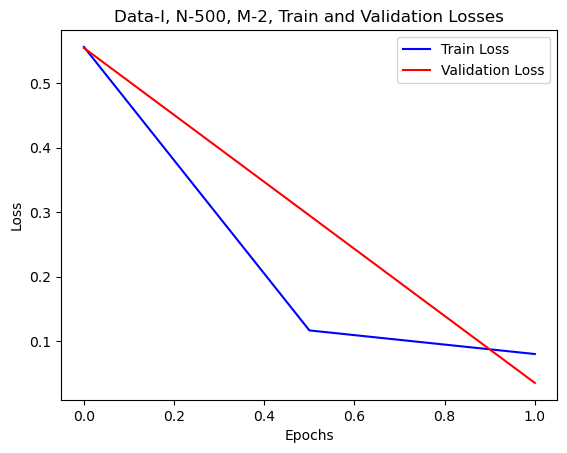

In [560]:
len_x = len(v_losses)
val_x = [i for i in range(0, len_x)]
train_x = [i/2 for i in range(0, len_x*2-1)]
print(val_x, train_x)

# Plot the train and validation losses
plt.plot(train_x,t_losses, label='Train Loss', color='blue')
plt.plot(val_x, v_losses, label='Validation Loss', color='red')

# Set labels and title for the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Data-{DSET_TYPE}, N-{N}, M-{M}, Train and Validation Losses')

# Add legend and show plot
plt.legend()
plt.show()


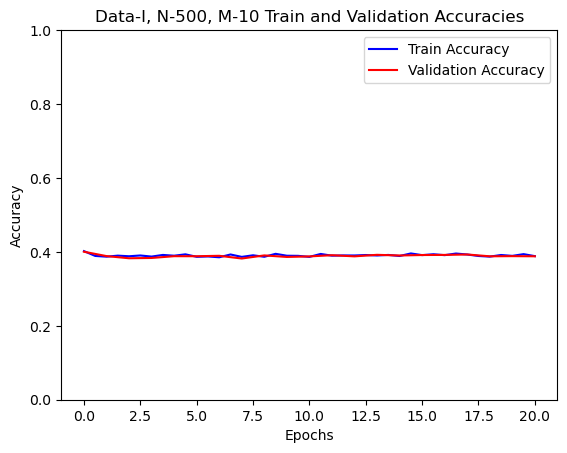

In [548]:
# Plot the train and validation accuracies
plt.plot(train_x,t_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_x, v_accuracies, label='Validation Accuracy', color='red')

# Set labels and title for the plot
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Data-{DSET_TYPE}, N-{N}, M-{M} Train and Validation Accuracies')
plt.ylim(0, 1)

# Add legend and show plot
plt.legend()
plt.show()


## Testing

In [471]:
# Prepare data for final evaluation of model
datafile = 'data/U_500.pkl'
indexfile = f'indices/{DSET_TYPE}_{N}_test.idx'

create_index(datafile, indexfile)
# test_set = dataset.LazyChemDataset(datafile, indexfile, M, N, transform=AddGaussianNoise())

test_set = rsample_dataset.RSampleDataset(
    pickle_file=datafile,
    index_file=indexfile,
    n_mixture=M,
    num_classes=N,
    transform=AddGaussianNoise(),
    total_samples=5000,
)

test_loader = DataLoader(test_set, batch_size=64, shuffle=True)


In [472]:
# Testing loop
def test(top_n):
    running_correct = 0
    all_labels = []
    all_preds = []

    # Loop through test_loader
    for mix, label in test_loader:
        if not mix.shape:  # Skip batches that somehow have no data
            continue
        outputs = model(mix).squeeze(1)
        predicted_probs = torch.sigmoid(outputs)  # Sigmoid to convert logits to probabilities
        predicted_labels = (predicted_probs > 0.7).float()  # Thresholding probabilities at 0.3
        # running_correct += (predicted_labels == label).float().sum().item()
        running_correct += top_n_accuracy(predicted_probs, label, n=top_n, correct_n=M)

        # Collect labels and predictions for F1 score calculation
        all_labels.append(label.cpu().numpy())
        all_preds.append(predicted_labels.cpu().numpy())

        # # Debugging output
        # print("True labels: ", label[0])
        # print("Predicted labels: ", predicted_labels[0])
        # print("Perfect match: ", torch.equal(label[0], predicted_labels[0]))
        print(predicted_probs, predicted_labels)


    # Calculate overall accuracy and F1 score
    accuracy = running_correct / len(test_loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')  # 'macro' averaging considers label imbalance
    f1_none = f1_score(all_labels, all_preds, average=None)

    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return accuracy, f1, f1_none


tensor([[2.5396e-16, 4.2509e-06, 3.6791e-03,  ..., 3.2584e-06, 1.6843e-05,
         3.8875e-01],
        [4.0715e-05, 6.6868e-05, 1.2496e-08,  ..., 2.1949e-06, 1.6757e-10,
         4.4235e-01],
        [6.6162e-20, 2.9275e-05, 1.2164e-24,  ..., 5.8062e-06, 7.4891e-07,
         1.8264e-04],
        ...,
        [4.6453e-04, 1.4812e-03, 2.3298e-20,  ..., 6.2553e-04, 1.0725e-07,
         1.1905e-03],
        [3.9553e-37, 7.6986e-04, 2.7100e-20,  ..., 1.5444e-05, 5.4182e-08,
         6.8957e-02],
        [1.2132e-03, 8.2536e-03, 1.0522e-34,  ..., 2.2380e-02, 7.4238e-04,
         2.6449e-04]], grad_fn=<SigmoidBackward0>) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1.8462e-32, 1.2559e-06, 1.0587e-18,  ..., 3.0507e-02, 3.9318e-01,
         1.3879e-02],
        [1.4023e-20, 8.07

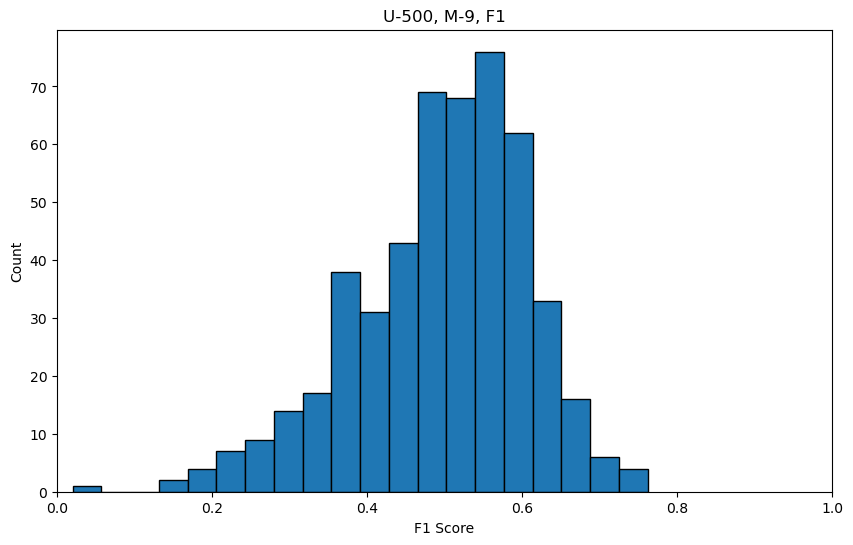

In [473]:
# Plot F1 Scores
_, _, f1_none = test(top_n=2)

# Create a bar plot of the F1 scores
plt.figure(figsize=(10, 6))
# plt.bar(range(N), f1_none, color='skyblue')
plt.hist(f1_none, edgecolor='k', bins=20)
plt.xlabel('F1 Score')
plt.ylabel('Count')
# plt.xticks(ticks=np.arange(0, N, 10), 
#            labels=[i for i in np.arange(0, N, 10)],
#            rotation=45)
plt.title(f'{DSET_TYPE}-{N}, M-{M}, F1')
# plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

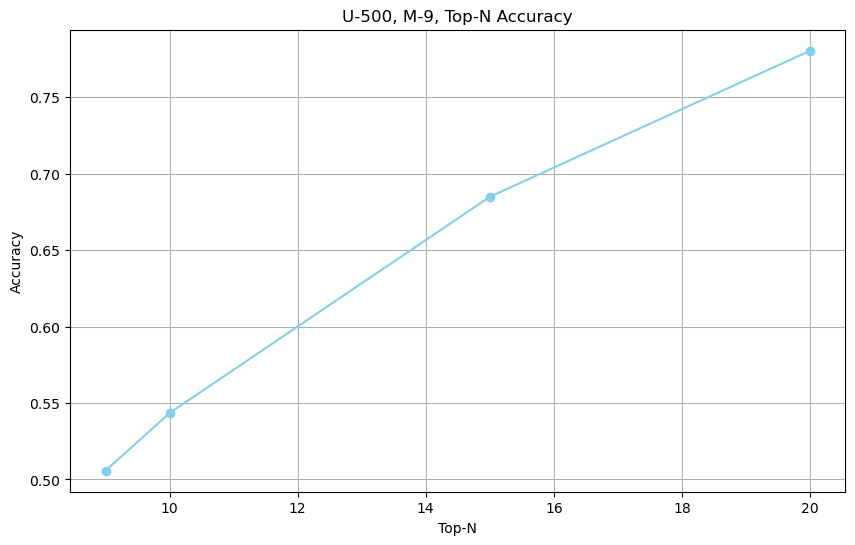

In [476]:
# Plot Top-n accuracy
accuracies = []
for i in [M, 10, 15, 20]:
    print(f"Top-{i} Accuracy:")
    accuracy, _, _ = test(i)
    accuracies.append(accuracy)

# Create a line plot of the top-n accuracies
plt.figure(figsize=(10, 6))
plt.plot([M, 10, 15, 20], accuracies, marker='o', color='skyblue')
plt.xlabel('Top-N')
plt.ylabel('Accuracy')
plt.title(f'{DSET_TYPE}-{N}, M-{M}, Top-N Accuracy')
plt.grid(True)
plt.show()